
# Generalize the internal effectiveness factor to different shapes, reaction orders, etc&#x2026;



You may find [these notes](http://jbrwww.che.wisc.edu/home/jbraw/chemreacfun/ch7/slides-masswrxn.pdf) helpful to augment the discussion here.




## Different particle shapes



In the previous example we derived the effectiveness factor for a spherical particle and first order reaction. These features determined the solution because the way we made the equations dimensionless was determined by a shape factor specific to the sphere, and the dimensionless Thiele modulus implicitly included the reaction rate law.

-   For other particle shapes, e.g. slabs or cylinders, we would use different characteristic lengths

-   For first order reactions, there are still analytical solutions available

-   Sphere $ \eta = \frac{1}{\Phi}  \left [\frac{1}{\tanh 3 \Phi} - \frac{1}{3 \Phi} \right]$
-   Cylinder $ \eta = \frac{1}{\Phi} \frac{I_1(2 \Phi)}{I_0(2\Phi)}   $
-   Slab $ \frac{\tanh \Phi}{\Phi} $

These solutions look functionally different, but they are actually quite similar:

scipy.special.iv [http://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.special.iv.html>](http://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.special.iv.html>)Modified Bessel function of the first kind of real order



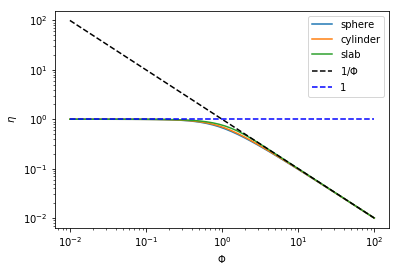

In [6]:
import numpy as np
from scipy.special import iv
import matplotlib.pyplot as plt

Phi = np.logspace(-2, 2)
eta_sphere = 1.0 / Phi * (1.0 / np.tanh(3 * Phi) - 1.0 / (3 * Phi))
eta_cylinder = 1 / Phi * iv(1, 2 * Phi) / iv(0, 2 * Phi)
eta_slab = np.tanh(Phi) / Phi

plt.loglog(Phi, eta_sphere, label='sphere')
plt.loglog(Phi, eta_cylinder, label='cylinder')
plt.loglog(Phi, eta_slab, label='slab')

plt.loglog(Phi, 1.0 / Phi, 'k--', label='1/$\Phi$')
plt.loglog(Phi,np.ones(shape=Phi.shape), 'b--', label='1')
plt.legend()
plt.xlabel('$\Phi$')
plt.ylabel('$\eta$')
plt.show()


-   The main point is that the main effects are not that sensitive to the particle geometry, with errors less than 20% in the effectiveness factor.

-   So, you should ignore the shape, and use the effectiveness factor for a sphere.




## Different reaction orders



-   Recall that the Thiele modulus contains an implicit reaction order in it, and we derived the solution for a first order reaction.

-   Let us consider the effectiveness factor now for reaction orders other than one.

-   For a spherical particle we have:

$ D_A \frac{1}{r^2} \frac{d}{dr} \left( r^2 \frac{d C_A}{dr}\right) - kC_A^n = 0 $

-   Let us again make the equation dimensionless.

-   This leads to:

$ \frac{1}{\overline{r}^2} \frac{d}{d\overline{r}}\left(\overline{r}^2\frac{d\overline{c}}{d\overline{r}}\right) - \frac{k C_{As}^{n-1}a^2}{D_A} \overline{c}^n = 0 $

-   with the new boundary conditions

$\overline{c}(\overline{r}=3) = 1 $

$ \frac{d\overline{c}}{d\overline{r}}=0 \textrm{ at } \overline{r}=0 $

-   Let us for now define $\tilde{\Phi}^2 = \frac{k C_{As}^{n-1}a^2}{D_A}$

-   We write out the differential equation as:

$\frac{d^2\overline{c}}{d\overline{r}^2} = -\frac{2}{\overline{r}}\frac{d\overline{c}}{d\overline{r}} + \tilde{\Phi}^2\overline{c}^n$

-   This is a particularly useful form because there is a function in pycse to solve this kind of BVP.

-   The effectiveness factor is defined as:

$\eta = \frac{1}{9}\int\limits_0^3 \overline{c}\overline{r}^2 dr$

-   or alternatively:

$\eta = \frac{1}{\tilde{\Phi}^2}\frac{d\overline{c}}{d\overline{r}}|_{r=3} = 0 $

-   The integral definition is more accurate to evaluate

-   Rather than use the shooting method (which does not work well for this nonlinear equation) we use a finite difference method (BVP\_nl) available in `pycse`

-   This is a nonlinear BVP, so we have to provide an initial guess for the solution. We will guess the concentration at the origin, and then use a polynomial function with slope=0 at the origin as an initial guess

-   See [http://jbrwww.che.wisc.edu/home/jbraw/chemreacfun/fig-html/fig-7-9.html>](http://jbrwww.che.wisc.edu/home/jbraw/chemreacfun/fig-html/fig-7-9.html>)for an alternative approach.

Note this takes longer than usual to run.

We consider three reaction orders here.



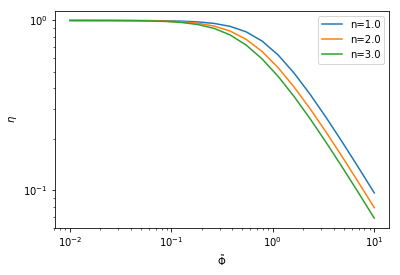

In [2]:
import numpy as np
from pycse.PYCSE import BVP_nl
import matplotlib.pyplot as plt

n = [1.0, 2.0, 3.0]     # reaction order

R = 3.0
r1 = 0
r2 = R

N = 300
RBAR = np.linspace(r1, r2, N)

THIELE = np.logspace(-2, 1, 20)

for order in n:
    ETA = []

    c0 = 0.9
    p = 4
    init = c0 + (1 - c0) / R**p * RBAR**p

    for thiele in THIELE:
        def F(rbar, cbar, dcbardrbar):
            return -2.0 / rbar * dcbardrbar + thiele**2 * cbar**order

        def BCS(rbar, cbar):
            return [(cbar[1] - cbar[0])/(rbar[1] - rbar[0]),  # dc/dr(r=0) = 0
                     cbar[-1] - 1]                            # cbar(R) = 1

        CBAR = BVP_nl(F, RBAR, BCS, init)
        eta2 = 1./9. * np.trapz(CBAR**order * RBAR**2, RBAR)
        ETA += [eta2]

    plt.loglog(THIELE, ETA, label='n={0}'.format(order))

plt.legend(loc='best')
plt.xlabel(r'$\tilde{\Phi}$')
plt.ylabel(r'$\eta$')
plt.show()

-   Note that unlike the case of different pellet shapes with n=1, the effectiveness factor changes a lot for different reaction orders.
    -   and there are different asymptotic limits at high &Phi;.

-   We can fix that by choosing a different definition of the Thiele modulus
    -   $ \Phi = \sqrt{\frac{n+1}{2} \frac{k c_{As}^{n-1} a^2}{D_A} } $

-   Then we have to modify the differential equation:

$\frac{d^2\overline{c}}{d\overline{r}^2} = -\frac{2}{\overline{r}}\frac{d\overline{c}}{d\overline{r}} + \frac{2}{n+1}\Phi^2\overline{c}^n$

Resolving this equation leads to:



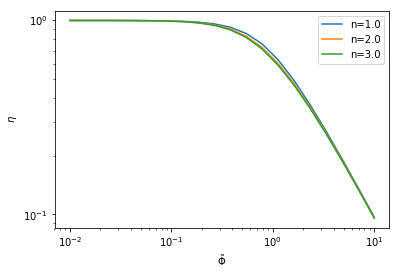

In [3]:
import numpy as np
from pycse.PYCSE import BVP_nl
import matplotlib.pyplot as plt

n = [1.0, 2.0, 3.0]     # reaction order

R = 3.0
r1 = 0
r2 = R

N = 300
RBAR = np.linspace(r1, r2, N)

THIELE = np.logspace(-2, 1, 20)

for order in n:
    ETA = []

    c0 = 0.9
    p = 4
    init = c0 + (1 - c0) / R**p * RBAR**p

    for thiele in THIELE:
        def F(rbar, cbar, dcbardrbar):
            return (-2.0 / rbar * dcbardrbar
                    + 2 / (order + 1) * thiele**2 * cbar**order)

        def BCS(rbar, cbar):
            return [(cbar[1] - cbar[0])/(rbar[1] - rbar[0]),  # dc/dr(r=0) = 0
                     cbar[-1] - 1]                            # cbar(R) = 1

        CBAR = BVP_nl(F, RBAR, BCS, init)
        eta2 = 1./9. * np.trapz(CBAR**order * RBAR**2, RBAR)
        ETA += [eta2]

    plt.loglog(THIELE, ETA, label='n={0}'.format(order))

plt.legend(loc='best')
plt.xlabel(r'$\tilde{\Phi}$')
plt.ylabel('$\eta$')
plt.show()


-   This scaling may seem arbitrary, but it effectively scales the equation so that it behaves like 1/&Phi; for large &Phi;.

-   It is not necessary, but it greatly simplifies design problems.
    -   It is difficult to solve the BVP, and the scaling shows it is not necessary to do that
    
    -   We use the modified Thiele modulus for n<sup>th</sup> order kinetics in combination with the analytical solution for 1<sup>st</sup> order reactions!

-   It is not clear why these equations are so hard to solve for different reaction orders. It may be instability in the method used to solve the BVP.

-   For other types of rate laws, there will be other types of Thiele moduli

-   The form of these will not be easy to guess and may contain other dimensionless groups
    -   They can be derived from asymptotic analysis




## Different rate laws



-   So far we have only considered power law kinetics.

-   In catalysis we often have rate laws like

$ r = k \overline{c}_m \frac{K_A c_A}{1 + K_A c_A} $

-   If we use this rate law in the diffusion/reaction equation, and make the equation dimensionless, we end up with two dimensionless numbers
    -   here is the equation for a slab

$ \frac{d^2\overline{c}}{d\overline{r}^2} - \tilde{\Phi}^2 \frac{\overline{c}}{1 + \phi \overline{c}} = 0  $

-   where the two dimensionless groups are

$ \tilde{\Phi} = \sqrt{\frac{k\overline{c}_m K_A a^2}{D_A}}  $

$ \phi = K_A C_{As}  $

-   Although one could use these equations to compute effectiveness factors, this is tedious as the result depends on &phi; and there is not a common asymptote at high values of &Phi;

-   Note this script takes quite a while to run.



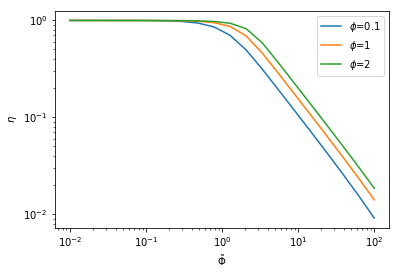

In [4]:
import numpy as np
from pycse.PYCSE import BVP_nl
import matplotlib.pyplot as plt

PHI = [0.1, 1, 2]
R = 1
r1 = 0
r2 = R

N = 300
RBAR = np.linspace(r1, r2, N)

THIELE = np.logspace(-2, 2, 20)

for phi in PHI:
    ETA = []

    c0 = 0.9
    p = 4
    init = c0 + (1 - c0) / R**p * RBAR**p

    for thiele in THIELE:
        def F(rbar, cbar, dcbardrbar):
            return thiele**2 * cbar / (1.0 + phi * cbar)

        def BCS(rbar, cbar):
            return [(cbar[1] - cbar[0])/(rbar[1] - rbar[0]),  # dc/dr(r=0) = 0
                     cbar[-1] - 1]                            # cbar(R) = 1

        CBAR = BVP_nl(F, RBAR, BCS, init)
        eta = ((1.0 + phi) / thiele**2
               * (CBAR[-1] - CBAR[-2])/(RBAR[-1] - RBAR[-2]))
        ETA += [eta]

    plt.loglog(THIELE, ETA, label='$\phi$={0}'.format(phi))

plt.legend(loc='best')
plt.xlabel(r'$\tilde{\Phi}$')
plt.ylabel(r'$\eta$')
plt.show()

-   You see a similar problem here as we saw with n<sup>th</sup> order kinetics. There is not a common asymptote.

-   While not unusable, it means we have to calculate this for every value of &phi;

-   Through an asymptotic analysis one arrives at the following scaled Thiele modulus:

$ \Phi = \left(\frac{\phi}{1 + \phi} \right) \frac{1}{\sqrt{2 (\phi - \ln(1+\phi))}} \tilde{\Phi} $

So, if we plug this in and re-solve the equations:



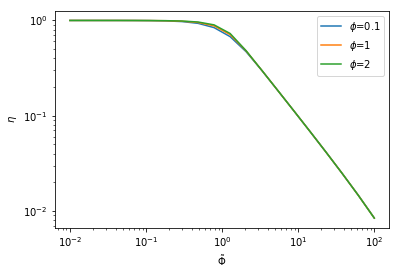

In [5]:
import numpy as np
from pycse.PYCSE import BVP_nl
import matplotlib.pyplot as plt

PHI = [0.1, 1, 2]
R = 1
r1 = 0
r2 = R

N = 300
RBAR = np.linspace(r1, r2, N)

THIELE = np.logspace(-2, 2, 20)

for phi in PHI:
    ETA = []

    c0 = 0.9
    p = 4
    init = c0 + (1 - c0) / R**p * RBAR**p

    for thiele_wiggle in THIELE:
        thiele = ((1.0 + phi)
                  / phi * np.sqrt(2 * (phi - np.log(1.0 + phi)))
                  * thiele_wiggle)

        def F(rbar, cbar, dcbardrbar):
            return thiele**2 * cbar / (1.0 + phi * cbar)

        def BCS(rbar, cbar):
            return [(cbar[1] - cbar[0])/(rbar[1] - rbar[0]),  # dc/dr(r=0) = 0
                     cbar[-1] - 1]                            # cbar(R) = 1

        CBAR = BVP_nl(F, RBAR, BCS, init)
        eta = ((1.0 + phi) / thiele**2
               * (CBAR[-1] - CBAR[-2])/(RBAR[-1] - RBAR[-2]))
        ETA += [eta]

    plt.loglog(THIELE, ETA, label=r'$\phi$={0}'.format(phi))

plt.legend(loc='best')
plt.xlabel(r'$\tilde{\Phi}$')
plt.ylabel(r'$\eta$')
plt.show()

-   We find reasonable asymptotic behavior

-   The payoff is that now we can readily estimate effectiveness factors by the original approach
    -   the analytical solution to a first order reaction in a spherical particle.
    -   We just have to use this definition of the Thiele modulus

$ \Phi = \left(\frac{\phi}{1 + \phi} \right) \sqrt{\frac{k \overline{c}_m K_A a^2}{2 (\phi - \ln(1+\phi)) D_A}} $

-   For large and small Thiele modulus the results will be good. For &Phi; &asymp; 1 there will be some error in the effectiveness factor.




# Summary of internal effectiveness factor



-   Particle shape effects are relatively small (e.g. a 20% effect)

-   We can reasonably estimate &eta; by choosing an appropriate Thiele modulus definition for the situation with $ \eta = \frac{1}{\Phi}  \left [\frac{1}{\tanh 3 \Phi} - \frac{1}{3 \Phi} \right]$
    -   for power law kinetics we use $ \Phi = \sqrt{\frac{n+1}{2} \frac{k c_{As}^{n-1} a^2}{D_A} } $
    
    -   For Hougen-Watson kinetics we use $ \Phi = \left(\frac{\phi}{1 + \phi} \right) \sqrt{\frac{k \overline{c}_m K_A a^2}{2 D_A(\phi - \ln(1+\phi))}} $



# Exam review

Things we've covered:
- Solving with multiple reactions
- Reversible reactions (where we need thermodynamics)
- Estimates on thermodynamics (from NIST, temperature scaling, etc)
- Estimating parameters from rate constant data: methods to estimate for nonlinear systems, uncertainty propagation
- Mechanism determination with multiple reactions, with some rate-limiting providing limits on kinetics and complex rate laws, including heterogeneous reactions
- Engineering trade-offs for reactor evaluation (cost/etc)
- Reaction/diffusion equations in particles: exact solutions, Thiele modulus, effectiveness factors, etc